# Sampling-Based Algorithms for Path Planning

![demo_animation.gif](img/demo_animation.gif)

In this lab, we will consider the problem of finding a path in continuous space for a point robot. For these purposes, we will use a sample-based approach.

The `Rapidly exploring Random Tree` (`RRT`) algorithm, is based on the idea of using a special data structure for planning in continuous space. In a tree, every node except the root has exactly one parent node. At every step, the algorithm creates a new node and try to connect it to the tree. The aim is to generate a node, which close to the goal configuration.

The stages of `RRT` grow at every algorithm step can be summarized as follows:
1) Make random point x<sub>rand</sub> by sampling in configuration space
2) Find the nearest to x<sub>rand</sub> tree node x<sub>near</sub> 
3) Extend the tree from x<sub>near</sub> in the direction of the point x<sub>rand</sub>, create  x<sub>new</sub>


The main advantages of the sampling-based algorithms are the possibility of using it for problems of finding paths in a continuous space, taking into account geometric (for example, the size or shape of the agent) and kinodynamic constraints. Such algorithms are also can be used to find solutions for high-dimensions problems (e.g. motion planning of robot arm), but in this lab we will consider the basic ideas of the sampled-based approach using the well-known problem of finding a path on a plane. To simplify a number of auxiliary operations, we will use a grid representation of the environment, although this algorithm allows us to operate in a completely continuous space.

In [1]:
!pip3 install kdtree

In [2]:

import math
import time
from sys import float_info
import random
import traceback
from heapq import heappop, heappush
from pathlib import Path
from textwrap import dedent
from typing import Callable, Dict, Iterable, List, Optional, Tuple, Type, Union
import os

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from PIL import Image, ImageDraw
import kdtree


%matplotlib inline
EPS = float_info.epsilon


## Grid Map Representation

In [3]:
class Map:
    """
    Represents a square grid environment for our moving agent.

    Attributes
    ----------
    _width : int
        The number of columns in the grid.

    _height : int
        The number of rows in the grid.

    _cells : np.ndarray
        A binary matrix representing the grid where 0 represents a traversable cell, and 1 represents a blocked cell.
    """

    def __init__(self, cells: npt.NDArray):
        """
        Initializes the map using a 2D array of cells.

        Parameters
        ----------
        cells : np.ndarray
            A binary matrix representing the grid. 0 indicates a traversable cell, and 1 indicates a blocked cell.
        """
        self._width = cells.shape[1]
        self._height = cells.shape[0]
        self._cells = cells

    def in_bounds(self, i: int, j: int) -> bool:
        """
        Checks if the cell (i, j) is within the grid boundaries.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        bool
            True if the cell is inside the grid, False otherwise.
        """
        return 0 <= j < self._width and 0 <= i < self._height

    def traversable(self, i: int, j: int) -> bool:
        """
        Checks if the cell (i, j) is not an obstacle.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        bool
            True if the cell is traversable, False if it's blocked.
        """
        return not self._cells[i, j]

    def get_neighbors(self, i: int, j: int) -> List[Tuple[int, int]]:
        """
        Gets a list of neighboring cells as (i, j) tuples.
        Assumes that the grid is 8-connected, allowing moves in cardinal and diagonal directions.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        neighbors : List[Tuple[int, int]]
            List of neighboring cells.
        """
        neighbors = []
        delta = ((0, 1), (1, 0), (0, -1), (-1, 0))
        for dx, dy in delta:
            ni, nj = i + dx, j + dy
            if self.in_bounds(ni, nj) and self.traversable(ni, nj):
                neighbors.append((ni, nj))

        delta = [(1, 1), (1, -1), (-1, -1), (-1, 1)]
        for dx, dy in delta:
            ni, nj = i + dx, j + dy
            if (
                self.in_bounds(ni, nj)
                and self.traversable(ni, nj)
                and self.traversable(i, nj)
                and self.traversable(ni, j)
            ):
                neighbors.append((ni, nj))

        return neighbors

    def get_size(self) -> Tuple[int, int]:
        """
        Returns the size of the grid in cells.

        Returns
        ----------
        (height, width) : Tuple[int, int]
            Number of rows and columns in the grid.
        """
        return self._height, self._width
    
    def get_cell_for_pos(self, x: float, y:float) -> Tuple[int, int]:
        """
        Returns cell that contains the point (x, y)
        """
        
        i = int(y)
        j = int(x)

        if i < 0:
            i = 0
        elif i > self._height - 1:
            i = self._height - 1

        if j < 0:
            j = 0
        elif j > self._width - 1:
            j = self._width - 1

        return i, j 
    
    def get_pos_for_cell(self, i: int, j: int) -> npt.NDArray:
        
        """
        Returns (i, j)-cell center position
        """
        
        return np.array([(j + 0.5), (i + 0.5)], dtype=np.float64) #check, maybe better to use y = i + 0.5


In [4]:
def convert_string_to_cells(cell_str: str) -> npt.NDArray:
    """
    Converts a string representation of a grid map, with '#' for obstacles and '.' for free cells, into a binary matrix.

    Parameters
    ----------
    cell_str : str
        String containing grid map information ('#' for obstacles and '.' for free cells).

    Returns
    ----------
    cells : np.ndarray
        Binary matrix representing the grid map.
    """
    lines = cell_str.replace(" ", "").split("\n")

    cells = np.array(
        [[1 if char == "#" else 0 for char in line] for line in lines if line],
        dtype=np.int8,
    )
    return cells

In [5]:
def compute_cost(i1, j1, i2, j2):
    """
    Computes the cost of simple moves between cells (i1, j1) and (i2, j2).

    Parameters
    ----------
    i1 : int
        Row number of the first cell in the grid.
    j1 : int
        Column number of the first cell in the grid.
    i2 : int
        Row number of the second cell in the grid.
    j2 : int
        Column number of the second cell in the grid.

    Raises
    ----------
    ValueError
        If trying to compute the cost of a non-supported move.
    """
    d = abs(i1 - i2) + abs(j1 - j2)
    if d == 1:  # Cardinal move
        return 1
    elif d == 2:  # Diagonal move
        return math.sqrt(2)
    else:
        raise ValueError("Trying to compute the cost of a non-supported move!")

## Rapidly-Exploring Random Tree Algorithm for Holonomic Point-Size Agent

In [6]:
class RRTNode:
    """
    Represents a search node for RRT algorithm.

    Attributes
    ----------
    state : npt.NDArray
        State in space corresponding to current node.
    parent : RRTNode
        Pointer to the parent node.
    trajectory : npt.NDArray
        Trajectory from parent node state to current state
    g : float | int
        Length of the path to the current node.
    """
    def __init__(self, 
                 state: npt.NDArray,
                 parent: "RRTNode" = None,
                 trajectory: npt.NDArray = None,
                 g: float = 0.0):
        """_summary_

        Parameters
        ----------
        state : npt.NDArray
            State in space corresponding to current node.
        parent : RRTNode, optional
            Pointer to the parent node., by default None
        trajectory : npt.NDArray, optional
           Trajectory from parent node state to current state, by default None
        g : float, optional
            Length of the path to the current node., by default 0.0
        """
        self.state = state
        self.parent = parent
        self.traj_from_parent = trajectory
        self.g = g

    def __len__(self):
        """
        The auxiliary method required for the correct operation of the KD-tree
        """
        return len(self.state)

    def __getitem__(self, i):
        """
        The auxiliary method required for the correct operation of the KD-tree
        """
        return self.state[i]

    def __repr__(self):
        return 'Vertex({}, {})'.format(self.state[0], self.state[1])

In [7]:
def metric(state1, state2):
    """
    Metric in the state space. In the current lab, the Euclidean distance between points on the plane is used.
    """
    return np.linalg.norm(state1 - state2)

In [8]:
class RRTree:
    """
    Search tree for RRT algorithm.
    """
    def __init__(self, root_node: RRTNode):
        """
        Initialize search tree with root in `root_node`

        Parameters
        ----------
        root_node : RRTNode
            Root node of the search tree
        """
        self._kd_tree = kdtree.create([root_node]) # KD-Tree for a fast search of neighbors in state space
        self._all_nodes = [root_node] # A list of all tree nodes required for visualization purposes

    def __len__(self):   
        """
        Returns the size of the search tree.
        """   
        return len(self._all_nodes)

    def add_node(self, item: RRTNode):
        """
        Adds node to the tree
        """
        self._kd_tree.add(item)
        self._all_nodes.append(item)

    def nearest_neighbour(self, state: npt.NDArray) -> RRTNode:
        """
        Finds nearest node in tree
        """
        return self._kd_tree.search_nn(state)[0].data
    
    @property
    def all_nodes(self):
        """
        Returns a list of all tree nodes required for visualization purposes
        """
        return self._all_nodes


In [9]:
def in_collision(state: npt.NDArray, 
                 state_space: Map,
                 *args) -> bool:
    """
    Checks the state is in conflict with the static environment.
    """
    return not state_space.traversable(*(state_space.get_cell_for_pos(*state)))

In [10]:
def create_random_state(state_space: Map, 
                        goal_bias: float, 
                        state_goal: npt.NDArray,
                        goal_sampling_region: float, 
                        *args) -> npt.NDArray:
    """
    Generates a random configuration in search space. 
    With probability `goal_bias` generates a state in the neighbourhood (`goal_sampling_region`) of the 2 goal state.
    """
    
    if np.random.random() < goal_bias:
        random_sample = np.array((random.uniform(-goal_sampling_region, goal_sampling_region), random.uniform(-goal_sampling_region, goal_sampling_region)))
        return state_goal + random_sample
    position = np.array((random.uniform(0, state_space.get_size()[1]), random.uniform(0, state_space.get_size()[0])))
    return position
    

In [11]:
def traj_with_collision(traj: npt.NDArray, state_space: Map, *args) -> bool:
    """
    Checks that the trajectory does not conflict with obstacles.
    
    Parameters
    ----------
    traj : npt.NDArray[npt.NDArray]
        Array of points which belongs to the trajectory.

    Returns
    -------
    bool :
        A boolean indicating if a trajectory has colissions. 
    """
    return any(in_collision(state, state_space, *args) for state in traj)
    

def create_new_state(state_initial: npt.NDArray, 
                     state_target: npt.NDArray, 
                     state_space: Map, 
                     *args) -> Tuple[bool, npt.NDArray, List[npt.NDArray]]:
    """
    Selects a new state by moving an incremental distance from state_initial, in the direction of state_target. 

    This function also runs the validation of the trajectory for conflicting with obstacles.

    Note that this lab considers the case when the maximum transition is limited. 
    The constraint is set as the first element of the *args
    """
    # Generation of a discrete trajectory in the direction of a target state, 
    # taking into account the maximum allowable transition
    max_transition = args[0]
    state_curr = state_initial.copy()
    direction = (state_target - state_initial)
    direction = direction / np.linalg.norm(direction)
    traj = [state_curr]
    dxdy = 0.01 # Step of discrete move
    transition = 0.0

    while transition < max_transition:
        state_curr += direction * dxdy
        traj.append(state_curr.copy())
        transition += dxdy
        
        direction = (state_target - state_curr)
        direction = direction / np.linalg.norm(direction)
    
    return traj_with_collision(traj, state_space), state_curr, traj


In [12]:
def extend(tree: RRTree, 
           state_space: Map, 
           state_random: npt.NDArray,
           *args) -> Optional[RRTNode]:
    """
    The key function of the RRT algorithm that builds up the search tree. 
    Note that this lab considers the case when the maximum transition is limited. 
    The constraint is set as the first element of the *args
    """
    near_node = tree.nearest_neighbour(state_random)
    traj_has_collision, state_new, traj = create_new_state(near_node.state, state_random, state_space, *args)
    
    if not traj_has_collision:
       neighbour_node = RRTNode(state=state_new, parent=near_node, trajectory=traj, 
                                g=near_node.g+metric(near_node.state, state_new))
       tree.add_node(neighbour_node)
       return neighbour_node
    
    return None


In [13]:
def in_goal_region(state: npt.NDArray, 
                   state_goal: npt.NDArray, 
                   region_size: float):
    """
    Checks if the state is close to the goal
    """
    return metric(state_goal, state) < region_size

In [14]:

def rrt(task_map: Map, 
        start_x: float, 
        start_y: float, 
        goal_x: float, 
        goal_y: float, 
        max_iter = 1000, 
        goal_region = 0.1,
        goal_bias = 0.05,
        *args) -> Tuple[bool, Optional[RRTNode], int, int, Optional[RRTree]]:
    """
    Implements the RRT search algorithm.

    Parameters
    ----------
    task_map : Map
        The grid or map being searched.
    start_x, start_y : float, float
        Starting coordinates.
    goal_x, goal_y : float, float
        Goal coordinates.
    max_iter : int
        Maximum number of iterations of the algorithm
    goal_region : float
        The size of the neighborhood of the goal state where the goal is considered to have been reached by the sample
    goal_bias : float
        The probability with which the state close to the goal is sampled

    Returns
    -------
    Tuple[bool, Optional[RRTNode], int, int, Optional[RRTree]]
        Tuple containing:
        - A boolean indicating if a path was found.
        - The last node in the found path or None.
        - Number of algorithm iterations.
        - Size of the resultant search tree.
        - RRT search tree for visualization or None.
    """
    node_start = RRTNode(np.array([start_x, start_y], dtype=np.float64), None, None, 0.0)
    state_goal = np.array([goal_x, goal_y], dtype=np.float64)
    tree = RRTree(node_start)
    
    steps = 0
    while steps < max_iter:
        steps += 1
        state_random = create_random_state(task_map, goal_bias, state_goal, goal_region, *args)
        new_node = extend(tree, task_map, state_random, *args)

        if not new_node is None:
            if in_goal_region(new_node.state, state_goal, goal_region):
                return True, new_node, steps, len(tree), tree
    
    return False, None, steps, len(tree), tree

In [15]:
def draw_circle(draw: ImageDraw, node: RRTNode, scale: float, radius: float, color: Tuple[int, int, int]):
    """Draws a circle, given the node (center position), radius and the desired color."""
    draw.ellipse(
        (
            (node.state[0] - radius/2) * scale,
            (node.state[1] - radius/2) * scale,
            (node.state[0] + radius/2) * scale,
            (node.state[1] + radius/2) * scale,
        ),
        fill=color,
        width=0,
    )

def draw_rrt(
    grid_map: Map,
    start: Optional[RRTNode] = None,
    goal: Optional[RRTNode] = None,
    path: Optional[Iterable[RRTNode]] = None,
    tree: Optional[RRTree] = None
):
    """
    Visualizes the environment, path, and search tree.

    Parameters
    ----------
    grid_map : Map
        Environment represented as a grid.
    start : Optional[RRTNode]
        Nodes for the start position of the agent, by default None
    goal : Optional[RRTNode]
        Nodes for the goal positions of the agent, by default None
    path : Optional[Iterable[RRTNode]]
        Sequence of nodes representing the path between start and goal, by default None
    tree : Optional[RRTree]
        Nodes that were added to the tree during the search process, by default None
    """

    scale = 30
    height, width = grid_map.get_size()
    im = Image.new("RGB", (width * scale, height * scale), color="white")
    draw = ImageDraw.Draw(im)

    tree_node_radius = 0.3
    path_node_radius = 0.4

    for i in range(height):
        for j in range(width):
            if not grid_map.traversable(i, j):
                draw.rectangle(
                    (j * scale, i * scale, (j + 1) * scale - 1, (i + 1) * scale - 1),
                    fill=(70, 80, 80),
                )


    if tree is not None:
        color = (131, 145, 146)
        for node in tree.all_nodes:
            draw_circle(draw, node, scale, tree_node_radius, color)

            traj = node.traj_from_parent
            if traj is None:
                continue

            for substep in range(len(traj)-1):
                point1 = (traj[substep][0] * scale, traj[substep][1] * scale)
                point2 = (traj[substep+1][0] * scale, traj[substep+1][1] * scale)
                draw.line((point1, point2), fill=(131, 145, 146), width=3)           

    if path is not None:
        color = (52, 152, 219)
        for step_num, step in enumerate(path):
            draw_circle(draw, step, scale, path_node_radius, color)
            traj = step.traj_from_parent

            if traj is None:
                continue
            
            for substep in range(len(traj)-1):
                point1 = (traj[substep][0] * scale, traj[substep][1] * scale)
                point2 = (traj[substep+1][0] * scale, traj[substep+1][1] * scale)
                draw.line((point1, point2), fill=(0, 0, 255), width=3)

    if start is not None:
        draw_circle(draw, start, scale, path_node_radius, (40, 180, 99))

    if goal is not None:
        draw_circle(draw, goal, scale, path_node_radius, (231, 76, 60))

    _, ax = plt.subplots(dpi=200)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))
    plt.show()

In [16]:
def input_adapter_rrt_holonomic(start_i: int, 
                                start_j: int, 
                                goal_i: int, 
                                goal_j: int, 
                                state_space: Map
                                ) -> Tuple[npt.NDArray, npt.NDArray, RRTNode, RRTNode]:
    
    """
    Input data adapter function for RRT search algorithm.

    Parameters
    ----------
    start_i, start_j : int, int
        Starting coordinates on grid.
    goal_i, goal_j : int, int
        Goal coordinates on grid.
    state_space : Map
        The grid or map being searched.

    Returns
    -------
    Tuple[npt.NDArray, npt.NDArray, RRTNode, RRTNode]
        Input data for RRT algorithm
    """
    state_start = state_space.get_pos_for_cell(start_i, start_j)
    state_goal = state_space.get_pos_for_cell(goal_i, goal_j)
    
    node_start = RRTNode(state_start)
    node_goal = RRTNode(state_goal)

    return state_start, state_goal, node_start, node_goal

## A* Algorithm

In [17]:
class AStarNode:
    """
    Represents a search node.

    Attributes
    ----------
    i : int
        Row coordinate of the corresponding grid element.
    j : int
        Column coordinate of the corresponding grid element.
    g : float | int
        g-value of the node.
    h : float | int
        h-value of the node (always 0 for Dijkstra).
    f : float | int
        f-value of the node (always equal to g-value for Dijkstra).
    parent : AStarNode
        Pointer to the parent node.
    """

    def __init__(
        self,
        i: int,
        j: int,
        g: Union[float, int] = 0,
        h: Union[float, int] = 0,
        f: Optional[Union[float, int]] = None,
        parent: "AStarNode" = None,
    ):
        """
        Initializes a search node.

        Parameters
        ----------
        i : int
            Row coordinate of the corresponding grid element.
        j : int
            Column coordinate of the corresponding grid element.
        g : float | int
            g-value of the node.
        h : float | int
            h-value of the node (always 0 for Dijkstra).
        f : float | int
            f-value of the node (always equal to g-value for Dijkstra).
        parent : AStarNode
            Pointer to the parent node.
        """
        self.i = i
        self.j = j
        self.g = g
        self.h = h
        if f is None:
            self.f = self.g + h
        else:
            self.f = f
        self.parent = parent

    def __eq__(self, other):
        """
        Checks if two search nodes are the same, which is needed to detect duplicates in the search tree.
        """
        return (self.i, self.j) == (other.i, other.j)

    def __hash__(self):
        """
        Makes the AStarNode object hashable, allowing it to be used in sets/dictionaries.
        """
        return hash((self.i, self.j))

    def __lt__(self, other):
        """
        Compares the keys (i.e., the f-values) of two nodes, needed for sorting/extracting the best element from OPEN.
        """
        return self.f < other.f

In [18]:
class SearchTreePQD:
    """
    SearchTree using a priority queue for OPEN and a dictionary for CLOSED.
    """

    def __init__(self):
        self._open = []  # Priority queue for nodes in OPEN
        self._closed = {}  # Dictionary for nodes in CLOSED (expanded nodes)
        self._enc_open_dublicates = 0  # Number of dublicates encountered in OPEN

    def __len__(self) -> int:
        """
        Returns the size of the search tree. Useful for assessing the memory
        footprint of the algorithm, especially at the final iteration.
        """
        return len(self._open) + len(self._closed)

    def open_is_empty(self) -> bool:
        """
        Checks if OPEN is empty.
        If true, the main search loop should be interrupted.
        """
        return len(self._open) == 0

    def add_to_open(self, item: AStarNode):
        """
        Adds a node to the search tree, specifically to OPEN. This node is either
        entirely new or a duplicate of an existing node in OPEN.
        This implementation detects duplicates lazily; thus, nodes are added to
        OPEN without initial duplicate checks.
        """
        heappush(self._open, item)

    def get_best_node_from_open(self) -> Optional[AStarNode]:
        """
        Retrieves the best node from OPEN, defined by the minimum key.
        This node will then be expanded in the main search loop.

        Duplicates are managed here. If a node has been expanded previously
        (and is in CLOSED), it's skipped and the next best node is considered.

        Returns None if OPEN is empty.
        """
        while True:
            if not self._open:
                return None
            
            best_node = heappop(self._open)
            
            if self.was_expanded(best_node): # node was expanded
                self._enc_open_dublicates += 1
                continue

            return best_node

    def add_to_closed(self, item: AStarNode):
        """
        Adds a node to the CLOSED dictionary.
        """
        self._closed[item] = item

    def was_expanded(self, item: AStarNode) -> bool:
        """
        Checks if a node has been previously expanded.
        """
        return item in self._closed

    @property
    def opened(self):
        return self._open

    @property
    def expanded(self):
        return self._closed.values()

    @property
    def number_of_open_dublicates(self):
        return self._enc_open_dublicates

In [19]:
def diagonal_distance(i1, j1, i2, j2):
    """
    Computes the Diagonal distance between two cells on a grid.

    Parameters
    ----------
    i1, j1 : int
        (i, j) coordinates of the first cell on the grid.
    i2, j2 : int
        (i, j) coordinates of the second cell on the grid.

    Returns
    -------
    int
        Diagonal distance between the two cells.
    """
    dx = abs(i1 - i2)
    dy = abs(j1 - j2)
    card_cost = 1
    diag_cost = math.sqrt(2)
    return card_cost * max(dx, dy) + (diag_cost - card_cost) * min(dx, dy)

In [20]:
def astar(
    task_map: Map,
    start_i: int,
    start_j: int,
    goal_i: int,
    goal_j: int,
    heuristic_func: Callable,
    search_tree: Type[SearchTreePQD],
) -> Tuple[bool, Optional[AStarNode], int, int, Optional[Iterable[AStarNode]], Optional[Iterable[AStarNode]]]:
    """
    Implements the A* search algorithm.

    Parameters
    ----------
    task_map : Map
        The grid or map being searched.
    start_i, start_j : int, int
        Starting coordinates.
    goal_i, goal_j : int, int
        Goal coordinates.
    heuristic_func : Callable
        Heuristic function for estimating the distance from a node to the goal.
    search_tree : Type[SearchTreePQD]
        The search tree to use.

    Returns
    -------
    Tuple[bool, Optional[AStarNode], int, int, Optional[Iterable[AStarNode]], Optional[Iterable[AStarNode]]]
        Tuple containing:
        - A boolean indicating if a path was found.
        - The last node in the found path or None.
        - Number of algorithm iterations.
        - Size of the resultant search tree.
        - OPEN set nodes for visualization or None.
        - CLOSED set nodes.
    """
    ast = search_tree()
    steps = 0

    start_node = AStarNode(start_i, start_j, g=0, h=heuristic_func(start_i, start_j, goal_i, goal_j))
    ast.add_to_open(start_node)

    while not ast.open_is_empty():
        steps += 1
        current_node = ast.get_best_node_from_open()

        # in lazy impementation we may expand all nodes, but duplicates are still exists
        if current_node is None:
            break

        if (current_node.i, current_node.j) == (goal_i, goal_j):
            return True, current_node, steps, len(ast), ast.opened, ast.expanded
        
        for neighbor_i, neighbor_j in task_map.get_neighbors(current_node.i, current_node.j):
            neighbor_g = current_node.g + compute_cost(current_node.i, current_node.j, neighbor_i, neighbor_j)
            neighbor_h = heuristic_func(neighbor_i, neighbor_j, goal_i, goal_j)  
            neighbor_node = AStarNode(neighbor_i, neighbor_j, g=neighbor_g, h=neighbor_h, parent=current_node)
            
            if not ast.was_expanded(neighbor_node):
                ast.add_to_open(neighbor_node)
        
        ast.add_to_closed(current_node)
  
    return False, None, steps, len(ast), None, ast.expanded

In [21]:
def draw_rectangle(draw, node, scale, color):
    """Draws a rectangle on the grid, given the node and the desired color."""
    draw.rectangle(
        (
            node.j * scale,
            node.i * scale,
            (node.j + 1) * scale - 1,
            (node.i + 1) * scale - 1,
        ),
        fill=color,
        width=0,
    )


def draw_astar(
    grid_map: Map,
    start: Optional[AStarNode] = None,
    goal: Optional[AStarNode] = None,
    path: Optional[Iterable[AStarNode]] = None,
    nodes_discovered: Optional[Iterable[AStarNode]] = None,
    nodes_expanded: Optional[Iterable[AStarNode]] = None,
    nodes_reexpanded: Optional[Iterable[AStarNode]] = None,
):
    """
    Visualizes the environment, path, and expanded/not yet expanded/re-expanded nodes.

    Re-expansions don't occur in Dijkstra's algorithm, but are included for potential future use.

    Parameters
    ----------
    grid_map : Map
        Environment represented as a grid.
    start, goal : Optional[AStarNode], Optional[AStarNode]
        Nodes for the start and goal positions of the agent.
    path : Optional[Iterable[AStarNode]]
        Sequence of nodes representing the path between start and goal.
    nodes_discovered : Optional[Iterable[AStarNode]]
        Nodes that were discovered during the search process.
    nodes_expanded : Optional[Iterable[AStarNode]]
        Nodes that were expanded during the search process.
    nodes_reexpanded : Optional[Iterable[AStarNode]]
        Nodes that were re-expanded during the search process.
    """
    scale = 30
    height, width = grid_map.get_size()
    im = Image.new("RGB", (width * scale, height * scale), color="white")
    draw = ImageDraw.Draw(im)

    # Draw blocked cells
    for i in range(height):
        for j in range(width):
            if not grid_map.traversable(i, j):
                draw.rectangle(
                    (j * scale, i * scale, (j + 1) * scale - 1, (i + 1) * scale - 1),
                    fill=(70, 80, 80),
                )

    node_colors = [
        (nodes_discovered, (213, 219, 219)),
        (nodes_expanded, (131, 145, 146)),
        (nodes_reexpanded, (255, 145, 146)),
    ]

    for nodes, color in node_colors:
        if nodes is not None:
            for node in nodes:
                draw_rectangle(draw, node, scale, color)

    if path is not None:
        for step_num, step in enumerate(path):
            color = (52, 152, 219) if grid_map.traversable(step.i, step.j) else (230, 126, 34)
            draw_rectangle(draw, step, scale, color)
            if step_num == 0:
                continue
            point1 = ((path[step_num-1].j + 0.5) * scale, (path[step_num-1].i + 0.5) * scale)
            point2 = ((step.j + 0.5) * scale, (step.i + 0.5) * scale)
            draw.line((point1, point2), fill=(0, 0, 255), width=3)

    if start is not None and grid_map.traversable(start.i, start.j):
        draw_rectangle(draw, start, scale, (40, 180, 99))

    if goal is not None and grid_map.traversable(goal.i, goal.j):
        draw_rectangle(draw, goal, scale, (231, 76, 60))

    _, ax = plt.subplots(dpi=200)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))
    plt.show()

In [22]:
def input_adapter_astar(start_i: int, 
                        start_j: int, 
                        goal_i: int, 
                        goal_j: int, 
                        state_space: Map) -> Tuple[Tuple[int, int], Tuple[int, int], AStarNode, AStarNode]:
    """
    Input data adapter function for A* search algorithm.

    Parameters
    ----------
    start_i, start_j : int, int
        Starting coordinates on grid.
    goal_i, goal_j : int, int
        Goal coordinates on grid.
    state_space : Map
        The grid or map being searched.

    Returns
    -------
    Tuple[Tuple[int, int], Tuple[int, int], AStarNode, AStarNode]
        Input data for A* algorithm
    """
    node_start = AStarNode(start_i, start_j)
    node_goal = AStarNode(goal_i, goal_j)

    return (start_i, start_j), (goal_i, goal_j), node_start, node_goal

## Experiment

Setting up random seed to secure the tests.

In [23]:
np.random.seed(2911)

In [24]:
def make_path(goal: AStarNode | RRTNode) -> Tuple[List[AStarNode | RRTNode], Union[float, int]]:
    """
    Creates a path by tracing parent pointers from the goal node to the start node.
    It also returns the path's length.

    Parameters
    ----------
    goal : AStarNode | RRTNode
        Pointer to the goal node in the search tree.

    Returns
    -------
    Tuple[List[AStarNode | RRTNode], float]
        Path and its length.
    """
    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

In [25]:
def simple_test(search_function: Callable, 
                input_adapter: Callable,
                draw_function: Callable,
                task: Union[int, None], 
                *args):
    """
    Function `simple_test` runs `search_function` on one task. Use a number from 0 to 24 to choose a specific debug task
    on a simple map, or use None to select a random task from this pool. The function displays:
     - 'Path found!' and some statistics if a path was found.
     - 'Path not found!' if a path was not discovered.
     - 'Execution error' if an error occurred during the execution of the search_function.
    In the first case, the function also provides a visualization of the task.

    Parameters
    ----------
    search_function : Callable
        Implementation of the search method.
    input_adapter : Callable
        Adapter function for algorithms with different input format
    draw_function : Callable
        Function for visualizing the search space and found paths
    task : int | None
        A number from 0 to 24 to choose a specific debug task on a simple map,
        or None to select a random task from this pool.
    *args
        Additional arguments passed to the search function.
    """

    def get_map_data():
        map_str = dedent(
            """
            . . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
            . . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
            . . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
            . . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
            . . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
            . . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
            . . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
            . . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
            . . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
            . . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
            . . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
            . . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
            . . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
            . . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
            . . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
        """
        )
        cells = convert_string_to_cells(map_str)
        return Map(cells)

    task_map = get_map_data()
    starts = [
        (9, 0),
        (13, 0),
        (7, 28),
        (14, 29),
        (4, 1),
        (0, 17),
        (5, 6),
        (5, 20),
        (12, 2),
        (7, 28),
        (11, 9),
        (3, 2),
        (3, 17),
        (13, 20),
        (1, 1),
        (9, 10),
        (14, 6),
        (2, 0),
        (9, 28),
        (8, 6),
        (11, 6),
        (3, 0),
        (8, 9),
        (14, 7),
        (12, 4),
    ]
    goals = [
        (11, 20),
        (2, 19),
        (6, 5),
        (4, 18),
        (9, 20),
        (7, 0),
        (2, 25),
        (12, 4),
        (3, 25),
        (0, 12),
        (4, 23),
        (2, 24),
        (9, 2),
        (1, 6),
        (13, 29),
        (14, 29),
        (2, 28),
        (14, 16),
        (13, 0),
        (1, 27),
        (14, 25),
        (10, 20),
        (12, 28),
        (2, 29),
        (1, 29),
    ]

    if (task is None) or not (0 <= task < 25):
        task = random.randint(0, 24)

    (
        state_start,
        state_goal,
        node_start,
        node_goal
    ) = input_adapter(*starts[task], *goals[task], task_map)

    try:
        (
            found,
            end_node,
            number_of_steps,
            search_tree_size,
            *other_results,
        ) = search_function(task_map, *state_start, *state_goal, *args)

        if found:
            path, path_length = make_path(end_node)
            draw_function(task_map, node_start, node_goal, path, *other_results)
            print(
                f"Path found! Length: {path_length:.3f}. Search tree size: {search_tree_size}. Number of steps: {number_of_steps}."
            )
        else:
            draw_function(task_map, node_start, node_goal, None, *other_results)
            print("Path not found!")
        return

    except Exception as e:
        print(f"Execution error: {e}")
        traceback.print_exc()

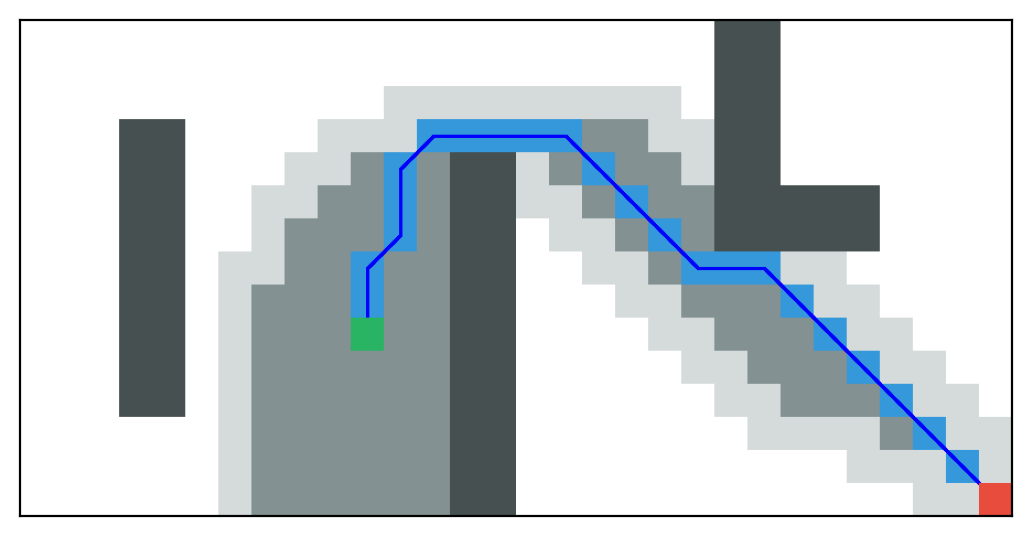

Path found! Length: 28.385. Search tree size: 307. Number of steps: 101.
CPU times: user 291 ms, sys: 37.8 ms, total: 328 ms
Wall time: 333 ms


In [26]:
%%time
simple_test(astar, input_adapter_astar, draw_astar, 15, diagonal_distance, SearchTreePQD)

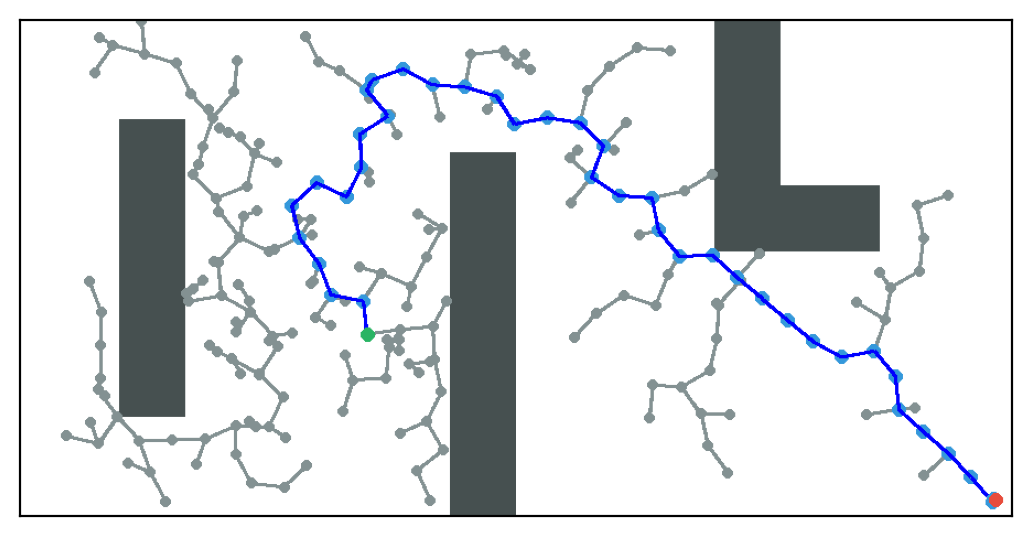

Path found! Length: 37.440. Search tree size: 211. Number of steps: 448.
CPU times: user 1.2 s, sys: 26.7 ms, total: 1.22 s
Wall time: 1.22 s


In [35]:
%%time
simple_test(rrt, input_adapter_rrt_holonomic, draw_rrt, 15, 1000, 0.1, 0.1, 1.0)

In [28]:
def read_map_from_movingai_file(
    path: str,
) -> npt.NDArray:
    """
    Reads map from a MovingAI .map file.

    Parameters
    ----------
    path : str
        Path to a file with the map.

    Returns
    -------
    cells : npt.NDArray
        Matrix of grid map cells.
    """
    with open(path) as map_file:
        next(map_file)
        height = int(next(map_file).split()[1])
        width = int(next(map_file).split()[1])
        next(map_file)

        # Read the map section
        map_lines = [next(map_file) for _ in range(height)]
        map_str = "".join(map_lines)
        cells = convert_string_to_cells(map_str)
    return cells

In [29]:
def read_tasks_from_movingai_file(path: str) -> List[Tuple[int, int, int, int, float]]:
    """
    Reads tasks from MovingAI .scen file

    Parameters
    ----------
    path : str
        Path to file with task

    Returns
    -------
    List[Tuple[int, int, int, int, float]]
        List of tasks. Each element of list contains:
        - start_i, start_j -- coordinates of start cell
        - goal_i, goal_j -- coordinates of goal cell
        - length -- length of shortest path
    """
    tasks = []
    with open(path) as tasks_file:
        next(tasks_file)
        for task_line in tasks_file:
            task_data = task_line.split()
            start_j = int(task_data[4])
            start_i = int(task_data[5])
            goal_j = int(task_data[6])
            goal_i = int(task_data[7])
            length = float(task_data[8])
            tasks.append((start_i, start_j, goal_i, goal_j, length))
    return tasks

In [30]:
def massive_test(search_function: Callable, 
                 input_adapter: Callable,
                 n_repeat: int,
                 *args):
    """
    The `massive_test` function runs the `search_function` on a set of different tasks (with repetition) using *args as optional arguments.
    For every task, it displays a short report:
     - 'Path found!' along with some statistics if a path was found.
     - 'Path not found!' if a path wasn't found.
     - 'Execution error' if an error occurred during the execution of the search_function.

    The function returns a dictionary containing statistics with the following keys:
     - "len" — the length of each path (0.0 if a path wasn't found).
     - "st_size" — the size of the resultant search tree for each task.
     - "steps" — the number of algorithm steps for each task.

    Parameters
    ----------
    search_function : Callable
        The implemented search method.
    input_adapter: Callable, 
        Adapter function for algorithms with different input format
    n_repeat : int
        The number of repetition of single task
    *args
        Additional arguments passed to the search function.

    Returns
    -------
    stat : Dict
        A dictionary containing statistics.

    """
    stat = {
        "len": [],
        "st_size": [],
        "steps": [],
    }

    task_from = 850
    task_to = 900
    directory = "data"
    maps = ["32room_000.map"]

    for map_file in maps:
        map_file_path = os.path.join(directory, map_file)
        cells = read_map_from_movingai_file(map_file_path)
        task_file_path = map_file_path + ".scen"
        tasks = read_tasks_from_movingai_file(task_file_path)
        task_map = Map(cells)
        task_count = 0
        for task_n in range(task_from, task_to):
            task_count += 1
            (start_i, start_j, goal_i, goal_j, true_length) = tasks[task_n]
            (
                state_start,
                state_goal,
                node_start,
                node_goal
            ) = input_adapter(start_i, start_j, goal_i, goal_j, task_map)
            lenghts = np.zeros(n_repeat, dtype=np.float64)
            sizes = np.zeros(n_repeat, dtype=np.float64)
            steps = np.zeros(n_repeat, dtype=np.float64)
            for repeat in range(n_repeat):
                try:
                    (
                        found,
                        end_node,
                        number_of_steps,
                        search_tree_size,
                        *other_results,
                    ) = search_function(task_map, *state_start, *state_goal, *args)

                    if found:
                        _, path_length = make_path(end_node)

                        print(
                            f"Task: #{task_count}. Path found! Length: {path_length}. Search tree size: {search_tree_size}. "
                            f"Number of steps: {number_of_steps}."
                        )
                        lenghts[repeat] = path_length
                        sizes[repeat] = search_tree_size
                        steps[repeat] = number_of_steps
                    else:
                        raise ValueError(f"Task: #{task_count}. Path not found!")
                except Exception as e:
                    print(f"Execution error: {e}")
                    traceback.print_exc()
            stat["len"].append(lenghts.mean())
            stat["st_size"].append(sizes.mean())
            stat["steps"].append(steps.mean())

    return stat

In [31]:
%%time
astar_res = massive_test(astar, input_adapter_astar, 1, diagonal_distance, SearchTreePQD)

Task: #1. Path found! Length: 248.1614716074875. Search tree size: 27053. Number of steps: 7498.


Task: #2. Path found! Length: 326.4213562373095. Search tree size: 61888. Number of steps: 17061.
Task: #3. Path found! Length: 317.22034611053294. Search tree size: 62762. Number of steps: 17970.
Task: #4. Path found! Length: 229.0121933088197. Search tree size: 6360. Number of steps: 1329.
Task: #5. Path found! Length: 293.6051224213833. Search tree size: 51751. Number of steps: 14720.
Task: #6. Path found! Length: 304.6396103067892. Search tree size: 16140. Number of steps: 3766.
Task: #7. Path found! Length: 319.55844122715797. Search tree size: 41715. Number of steps: 11790.
Task: #8. Path found! Length: 277.8284271247462. Search tree size: 3493. Number of steps: 741.
Task: #9. Path found! Length: 322.43860018001254. Search tree size: 21192. Number of steps: 5306.
Task: #10. Path found! Length: 290.3553390593273. Search tree size: 6680. Number of steps: 1321.
Task: #11. Path found! Length: 323.5462479183379. Search tree size: 58394. Number of steps: 16810.
Task: #12. Path found! L

In [32]:
%%time
rrt_res = massive_test(rrt, input_adapter_rrt_holonomic, 10, 10000, 0.1, 0.5, 10.0)

Task: #1. Path found! Length: 249.49000000006944. Search tree size: 38. Number of steps: 37.
Task: #1. Path found! Length: 254.3399999999683. Search tree size: 52. Number of steps: 51.
Task: #1. Path found! Length: 262.6500000000476. Search tree size: 40. Number of steps: 39.
Task: #1. Path found! Length: 246.0499999999093. Search tree size: 51. Number of steps: 50.
Task: #1. Path found! Length: 254.4799999999782. Search tree size: 40. Number of steps: 39.
Task: #1. Path found! Length: 243.5000000000622. Search tree size: 49. Number of steps: 48.
Task: #1. Path found! Length: 278.67000000006095. Search tree size: 46. Number of steps: 45.
Task: #1. Path found! Length: 274.26000000022594. Search tree size: 50. Number of steps: 49.
Task: #1. Path found! Length: 247.98000000004845. Search tree size: 40. Number of steps: 39.
Task: #1. Path found! Length: 253.10000000004987. Search tree size: 38. Number of steps: 37.
Task: #2. Path found! Length: 359.1999999999167. Search tree size: 44. Numb

In [34]:
astar_res_len = np.array(astar_res["len"])
rrt_res_len = np.array(rrt_res["len"])

astar_res_steps = np.array(astar_res["steps"])
rrt_res_steps = np.array(rrt_res["steps"])

astar_res_size = np.array(astar_res["st_size"])
rrt_res_size = np.array(rrt_res["st_size"])

astar_name = "A*"
rrt_name = "RRT"
print("Average Path Length")
print("--------------------------------------")
print(f"{astar_name:7} {astar_res_len.mean():.04f} | {rrt_name:7} {rrt_res_len.mean():.04f}")
print("--------------------------------------")
print()
print("Average Search Step Count")
print("--------------------------------------")
print(f"{astar_name:7} {astar_res_steps.mean():.04f} | {rrt_name:7} {rrt_res_steps.mean():.04f}")
print("--------------------------------------")
print()
print("Average Search Tree Size")
print("--------------------------------------")
print(f"{astar_name:7} {astar_res_size.mean():.04f} | {rrt_name:7} {rrt_res_size.mean():.04f}")
print("--------------------------------------")

Average Path Length
--------------------------------------
A*      300.0287 | RRT     313.4689
--------------------------------------

Average Search Step Count
--------------------------------------
A*      9597.9200 | RRT     45.5400
--------------------------------------

Average Search Tree Size
--------------------------------------
A*      34775.9000 | RRT     46.5400
--------------------------------------
